In [102]:
%matplotlib inline

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
from sklearn.decomposition import PCA as sklearnPCA

# Principal Component Analysis: Prerequisites and Implementation

### Author Dimitar Todev

## Abstract

Principal component analysis (PCA) is a dimensionality reduction technique. It transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components while retaining as much as possible of the variation present in the data set. A lot of mathematical and statistical concepts should be covered in order for PCA to make sense. 

This paper goes through the most important ideas behind PCA and implements the algorithm in Python. 



## Introduction 

PCA is really useful when it comes to finding patterns in data of high dimensions. First we will build a good foundation by introducing different concepts that will be used in PCA. It starts with some linear algebra. More specifically eigenvalues and their corresponding eigenvectors. Then it goes through a little bit of statistics by exploring mean, variance and covariance matrix. Then it delves into a step-by-step implementation of PCA from scratch.  

## Eigenworld 
Before we dive deep into implementing PCA, there are a few mathematical concepts from linear algebra that are essential prerequisites. More specifically, eigenvalues, eigenvectors and eigenbasis. The word "eigen" comes from German and means "own". Ironically, these notions are a necessity if one wants to be sure in their "eigen" comprehension of PCA. 

### Eigenvalues and Eigenvectors

Eigenvalues and eigenvectors have a lot of applications outside of math textbooks. They are commonly used in the fields of computer vision and machine learning. Some interesting examples are [object recognition](http://www.cipa.dcu.ie/papers/spie_97.pdf), Google's [PageRank algorithm](https://www.rose-hulman.edu/~bryan/googleFinalVersionFixed.pdf) and obviously PCA. The best way to understand what is happening behind the curtains is to show things visually.     


In [104]:
def visualize_transformation(matrix, vector, plot_title):
    """
    Plots the linear transformation given by the specified matrix
    """
    plt.axis("equal")
    ax = plt.gca()

    # Limits, labels and grid
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1] + 1))
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    ax.set_title(plot_title)

    # Unit vectors
    ax.quiver([0, 0], [0, 0], [1, 0], [0, 1],  color=[
              "red", "blue"], alpha=0.35, units="xy", scale=1)

    # Example vector
    ax.quiver([vector[0], 0], [vector[1], 0],  color=[
          "green"], alpha=0.35, units="xy", scale=1)

    # Transformation
    t = Affine2D(matrix)

    [min_x, max_x, min_y, max_y] = [2 * ax.get_xlim()[0], 2 * ax.get_xlim()
                                    [1] + 1, 2 * ax.get_ylim()[0], 2 * ax.get_ylim()[1] + 1]

    # New (transformed) grid lines
    # Horizontal
    for y in np.arange(min_y, max_y):
        ax.plot([min_x, max_x], [y] * 2, color="red", linestyle="-",
                linewidth=2, transform=t + ax.transData)
    # Vertical
    for x in np.arange(min_x, max_x):
        ax.plot([x] * 2, [min_y, max_y], color="blue", linestyle="-",
                linewidth=2, transform=t + ax.transData)

    # New (transformed) unit vectors
    new_x = t.transform_affine([1, 0])
    new_y = t.transform_affine([0, 1])

    # Transformed example vector
    transformed_vector = np.array(matrix).dot(np.array(vector))
    
    ax.quiver([0, 0], [0, 0], [new_x[0], new_y[0]], [
              new_x[1], new_y[1]], color=["red", "blue"], units="xy", scale=1)
    
    ax.quiver([transformed_vector[0], 0], [transformed_vector[1], 0],  color=[
              "green"], alpha=1, units="xy", scale=1)
    
    # Adding a legend for the vectors
    red_patch = mpatches.Patch(color='red', label='i')
    blue_patch = mpatches.Patch(color='blue', label='j')
    if vector != [0, 0, 0]:
        green_patch = mpatches.Patch(color='green', label='v')
        plt.legend(loc="upper right", handles=[red_patch, blue_patch, green_patch])
    else: 
        plt.legend(loc="upper right", handles=[red_patch, blue_patch])
    
    plt.show()

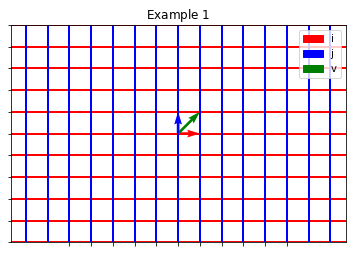

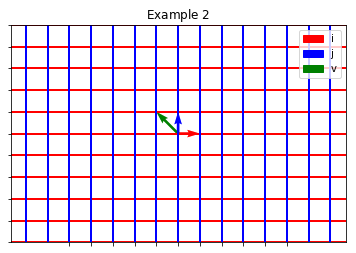

In [107]:
matrix = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]

vector = [1, 1, 0]
visualize_transformation(matrix, vector, r"$\mathrm{Example\ 1}$")

vector = [-1, 1, 0]
visualize_transformation(matrix, vector, r"$\mathrm{Example\ 2}$")

To find out what makes eigenvectors so special we are going to look at two examples. A major point of interest for us would be the green vector $ \vec{v} $. In the first example $ \vec{v} $ has coordinates $
\begin{bmatrix}
    1      \\
    1      
\end{bmatrix}
$ and in the second 
$\begin{bmatrix}
    -1      \\
    1      
\end{bmatrix}$. Now let's see what happens to it after a simple linear 2D transformation. 

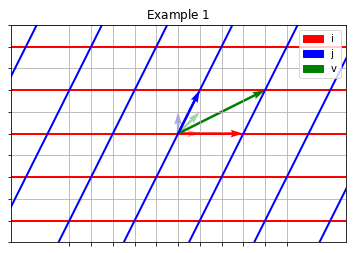

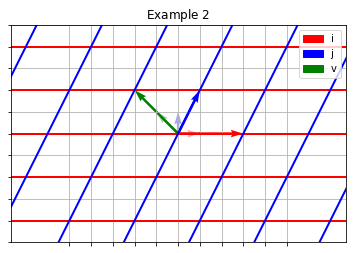

In [108]:
matrix = [
    [3, 1, 0],
    [0, 2, 0],
    [0, 0, 1]
]

vector = [1, 1, 0]
visualize_transformation(matrix, vector, r"$\mathrm{Example\ 1}$")

vector = [-1, 1, 0]
visualize_transformation(matrix, vector, r"$\mathrm{Example\ 2}$")

The transformation I have shown is represented with the matrix $\begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix}$. If we now compare the two examples after the transformation we can observe something interesting. In the first one $ \vec{v} $ gets knocked off its span (or the line passing through its origin and its tip). This is true for most vectors. It would be rather peculiar if the place where the vector landed is somewhere on that line. Interestingly enough, there are some special vectors that do remain on their span. That is the case in the second example. 

The effects of the matrix on such a vector are to stretch it or squish it like s scalar. If we observe more carefully, we can see that $\vec{v}$ is not the only plotted special vector. The same applies to $\hat{\imath}$ whose span is the x-axis. After the transformation it moves over to three times itself, landing on $\begin{bmatrix}
    3      \\
    0      
\end{bmatrix}$ still on the x-axis. This can also be said for any other vector on that axis, it will be streched by a factor of 3, remaining on its own span. $\vec{v}$ and all other vectors on that diagonal span, on the other hand get sctreched by a factor of 2. For this particular transformation, these are the only two vectors with this special property. 

As you might have guessed by now, those special vectors are called the eigenvectors of the transformation. Each eigenvector comes with its own eigenvalue or the factor by which it is streched or squished during the transformation. For this transformation the eigenvalue of $\vec{v}$ is 2 and the one of $\hat{\imath}$ is 3. 

**An eigenvector is a vector whose direction remains unchanged when a linear transformation is applied to it.**

Having visually shown what an eigenvector is, it is time to represent it with a basic equation: $A\vec{v}=\lambda \vec{v}$ 

$A$ is the transformation matrix, $\vec{v}$ represents the eigenvector and $\lambda$ is the corresponding eigenvalue. What this equation is saying is that the product of the matrix-vector multiplication ($A$ * $\vec{v}$) gives the same result as scaling the eigenvector $\vec{v}$ by some value $\lambda$. 

In order to find the eigenvectors and their eigenvalues for the matrix $A$, we have to solve the equation for $\lambda$ and $\vec{v}$. Since the right side of the equation is scalar multiplication, it should be tweaked a little bit. The equation can be rewritten as: $A\vec{v}=(\lambda I) \vec{v}$ where $I$ is the identity matrix of the same dimensions as $A$. Now both sides represent matrix-vector multiplication and the equation can be formatted once again as $(A - \lambda I) \vec{v} = 0$  

It should be noted that vector $\vec{v} = 0$ satisfies the equation. However, we search for less trivial, nonzero solutions. 

That being said, the only way for a product of a matrix and nonzero vector to be zero is if the determinant of the matrix is 0. Consequently, to find the eigenvectors of the matrix we have to solve: $\det(A - \lambda I) = 0$. A zero determinant means that the matrix is not invertible and that the transformation associated with that matrix squishes space to a lower dimension. 

Now that we have seen both visually and symbolically what this mathematical concept is, it is time we did some calculations.

### Computing the eigenvalues and the eigenvectors of a matrix 

We will use the same matrix as before $A = \begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix}$

$$\det(A - \lambda I)$$ 

$$= \det\Bigg(\begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix} - \lambda\begin{bmatrix}
    1 & 0      \\
    0 & 1      
\end{bmatrix}\Bigg)$$ 

$$= \det\Bigg(\begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix} -  \begin{bmatrix}
    \lambda & 0      \\
    0 & \lambda      
\end{bmatrix}\Bigg)$$ 

$$= \det\Bigg(\begin{bmatrix}
    3 - \lambda & 1      \\
    0 & 2 - \lambda      
\end{bmatrix}\Bigg)$$

$$= (3 - \lambda) (2 - \lambda) = 0 $$

The eigenvalues of $A$ are the solutions of the equation, namely $\lambda_1 = 2$ and $\lambda_2 = 3$. They can be referred to as the spectrum of $A$.  

First we work with $\lambda_1$ and the equation $A\vec{v}=\lambda \vec{v}$ becomes $A\vec{v}=2\vec{v}$. Then, we write $\vec{v}$ as  $\begin{bmatrix}
    x_1     \\
    x_2      
\end{bmatrix}$. Using the matrix $A$ we have 

$$ \begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix} \begin{bmatrix}
    x_1      \\
    x_2      
\end{bmatrix} =  2 \begin{bmatrix}
    x_1      \\
    x_2      
\end{bmatrix} $$ or

$$ \begin{bmatrix}
    3x_1 + 1x_2      \\
    0x_1 + 2x_2      
\end{bmatrix} =  \begin{bmatrix}
    2x_1      \\
    2x_2      
\end{bmatrix} $$

After we solve $3x_1 + x_2 = 2x_1$ and $0x_1 + 2x_2 = 2x_2$ for $x_1$ and $x_2$, we find out that the solutions associated with the eigenvalue $\lambda = 2$ are all the vectors on the diagonal line spanned by $-1$ and $1$. Therefore, one such eigenvector is $\vec{v} = $$ \begin{bmatrix}
    -1     \\
    1      
\end{bmatrix}$. Similarly, for $\lambda = 3$, the solutions are all scalar multiples of  $\begin{bmatrix}
    1     \\
    0      
\end{bmatrix}$.

Calculating eigenvalues and eigenvectors in Python is a bit easier.

In [6]:
def compute_eigvals_and_eigvecs(matrix):
    """ 
    Computes eigenvectors and eigenvalues of a square matrix 
    """
    evals, evecs = np.linalg.eig(matrix)
    return "The eigenvalues are {0}\nThe eigenvectors are \n{1}".format(evals, evecs)

In [7]:
A = np.matrix([
    [3, 1],
    [0, 2]
  ])

print(compute_eigvals_and_eigvecs(A))

The eigenvalues are [3. 2.]
The eigenvectors are 
[[ 1.         -0.70710678]
 [ 0.          0.70710678]]


### Eigenbasis

Let's imagine for a second that $\hat{\imath}$ is scaled by $-2$ and $\hat{\jmath}$ is scaled by $3$, so that their new coordinates are $\begin{bmatrix}
    -2       \\
    0      
\end{bmatrix}$ and $\begin{bmatrix}
    0       \\
    3      
\end{bmatrix}$.

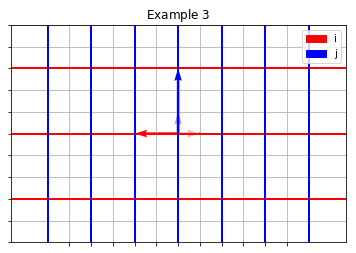

In [8]:
matrix = [
    [-2, 0, 0],
    [0, 3, 0],
    [0, 0, 1]
]

vector = [0, 0, 0]
visualize_transformation(matrix, vector, r"$\mathrm{Example\ 3}$")

It turns out that both basis vectors are also eigenvectors. The matrix that represents the transformation is $\begin{bmatrix}
    -2 & 0      \\
    0 & 3      
\end{bmatrix}$. This is an example for what is called a diagonal matrix. Every other entry except $\hat{\imath}$ and $\hat{\jmath}$ (the diagonal) is zero. In this case every basis vector is an eigenvector with an eigenvalue being the corresponding diagonal entry of the matrix. Some computations are much easier when one works with a diagonal matrix. For example if we multiply a matrix by itself. 

However, chances are slim that the basis vectors will often be eigenvectors. In fact that would rarely happen. But if a transformation has a lot of eigenvectors, we can choose a set and change the coordinate system so that the chosen vectors become the basis vectors.

In the previous examples we found out that the eigenvectors of the matrix $A = \begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix}$ are $\begin{bmatrix}
    1     \\
    0      
\end{bmatrix}$ and $\begin{bmatrix}
    -1     \\
    1      
\end{bmatrix}$. To change the basis of the vectors we make a matrix out of the coordinates we want to use as new basis vectors $\begin{bmatrix}
    1 & -1     \\
    0 & 1    
\end{bmatrix}$ (in this case the eigenvectors). To find out the new matrix that represents the original transformation from the perspective of the new basis vector coordinate system use the following: 

$$\begin{bmatrix}
    1 & -1     \\
    0 & 1    
\end{bmatrix}^{-1}\begin{bmatrix}
    3 & 1      \\
    0 & 2      
\end{bmatrix}\begin{bmatrix}
    1 & -1     \\
    0 & 1    
\end{bmatrix}$$

The original matrix is between the matrix we created from the eigenvectors on the right and the inverse of that same matrix on the left. The result is always guranteed to be a diagonal matrix. For this particular example it looks like this: $\begin{bmatrix}
    3 & 0     \\
    0 & 2    
\end{bmatrix}$. A diagonal matrix is often easier to work with.

**An eigenbasis is a set of basis vectors that are also eigenvector**

If a matrix has enough eigenvectors and we need to do some computations, we may want to use a diagonal matrix for convenience. To do that, we change to an eigenbasis, do the computations and then convert back to the original system. 

By now, we should (hopefully) have a solid grasp of the concept of eigenvalues and eigenvectors. We will come back to this eigenworld when we start implementing PCA to see how everything falls into place. 

## A few more prerequisites

We have to quickly go through some basic statistical concepts to ensure we get the full picture. More specifically mean, variance, standard deviation and covariance.

**Mean** is one of the most important ideas in statistcs. Curiously enough, it is really intuitive and most people know about it. It can be simply described as the average of a range of values in a set. It is found by summing all data points and dividing them by the number of data point. 

**Variance** $(\sigma^2)$ measures how far a data set is spread out. It is the average of the squared differences from the Mean. There are three steps to calculate it. First, we find out the mean of the dataset. Then, for each number we subtract the mean and square the result (to get positive values) and finally we work out the average of these differences.  

The formula for variance is: 

$$\sigma^2_x = \frac{1}{N}\sum_{i=1}^{N}(x_i - \bar{x})^2$$

where $N$ is the number of elements, $x_i$ is the value of the ith elements and $\bar{x}$ is the mean of the dataset. 

The dataset that we are going to use for our example is $3$, $5$, $6$, $8$, $9$

We start by finding the mean of the dataset:

$$\overline{X} = \frac{(3 + 5 + 6 + 7 + 9)}{5} = 6$$ 

To find the variance we need the average of the squared differences.  

$$\sigma^2 = \frac{(3 - 6)^2 + (5 - 6)^2 + (6 - 6)^2 + (7 - 6)^2 + (9 - 6)^2}{5} = 4$$

It is important to be noted that in this example the data is from a population. Meaning it is a set that contains all members of a group. That is why we divided by $N$ or $5$. If it was a sample set (a subset of a population that contains some members of it), we would have divided the sum by $N - 1$ or in this case $4$ .

The next thing we can do is find the **standard deviation**. The formula is rather simple. It is the square root of the variance $\sigma = \sqrt{4}$.

Of course, in this case none of this information tells us anything about the real world. This is because we used random numbers for data set. However, in other situations the standard deviation is really useful. It gives us a "standard" by which we can compare what is normal. A low standard deviation means that most of the numbers are close to the average. A high standard deviation means that the numbers are more spread out. 

**Covariance**, on the other hand, measures how random variables change (or don't change) together. For example if one goes up or down, what happens to the other. Like the height of the person and the weight of a person. The variance of a random variable $x$ can be expressed as the covariance with itself by $\sigma(x, x)$. The formula for covariance is pretty simillar to the variance one.

$$\sigma(x, y) = \frac{1}{N}\sum_{i=1}^{N}(x_i - \bar{x})(y_i - \bar{y})$$

Covariance can be used to calculate entries of the covariance matrix. It is a square $d$x$d$ matrix where $d$ describes the dimension. The diagonal entries of the covariance matrix are the variances and the other entries are the covarariances. A 2D covariance matrix looks like this: $\begin{bmatrix}
    \sigma(x, x) & \sigma(x, y)      \\
    \sigma(y, x) & \sigma(y, y)      
\end{bmatrix}$

With that said, we are ready to start our exploration of what principal component analysis is and how we can implement it. Any other concepts will be explained on the go.  

## Principal Component Analysis

PCA is a linear transformation method for reducing the dimensionality of data. It transforms a large set of variables into a smaller one while preserving as much information as possible. Smaller data sets are easier to analyze and work with. Ultimately, machine learning algorithms run faster with smaller data sets. The idea of PCA is to trade a bit of accuracy for speed and ease. We do so by projecting the entire set of data onto a different subspace. 

Let's say we have a $d$-dimensional dataset and we want reduce its dimensionality by projecting it onto a $k$-dimensional subspace where $k < d$ and the loss of information is minimal. The question here arises: how do we know what size we should choose for $k$? 

Here is where our knowledge for eigenvectors and eigenvalues comes into play. At one point we will have to compute and collect them in a covariance matrix. The eigenvalue will tell us about the "length" or "magnitude" of the eigenvectors. If the eigenvalues are of simillar magnitude, this is a good indicator that the data is already in a "good" subspace. If some eigenvalues are of much higher than others, we may want to keep only those with higher eigenvalues because they contain more information. On the other hand, eigenvalues close to zero are do not give much information and we might consider dropping them when we construct the new subspace.

### Steps for PCA  

Our implementation of PCA is based on the following steps: 

<ol>
    <li> Generate sample data </li>
    <li> Compute mean vector and covariance matrix of original points </li>
    <li> Compute and sort eigenvectors and eigenvalues </li>
    <li> Sort them and select top $k$ eigenvectors</li>
    <li> Form a new matrix and transform samples onto the new subspace</li>
</ol>


### Generating sample data

To implement a principal component analysis, we will need some sample data on which to perform it. So before going any further, we should generate some. For this example, we will start with a 3-dimensional dataset and then reduce it to a 2D one. Thus, the whole process of "Dimensionality reduction" could be visualized. 

We will generate 40 3D samples randomly drawn from a multivariate normal distribution. 

In [80]:
np.random.seed(1) # random seed for consistency

sample_mean1 = np.array([0,0,0])
sample_mean2 = np.array([1,1,1])

sample_covariance_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Draws random samples from a multivariate normal distribution.
class1_samples = np.random.multivariate_normal(sample_mean1, sample_covariance_matrix, 20).T
class2_samples = np.random.multivariate_normal(sample_mean2, sample_covariance_matrix, 20).T

# Checks if the matrices have the right dimensions
assert class1_samples.shape == (3,20), "The matrix does not have dimensions 3x20"
assert class2_samples.shape == (3,20), "The matrix does not have dimensions 3x20"

The code above created two $3$ x $20$ datasets. Each column can be pictured as a 3-dimensional vector that looks like this $\begin{bmatrix}
    x_1       \\
    x_2       \\
    x_3
\end{bmatrix}$. 
<br>To get an idea how the samples of the two classes are distrubed, we should plot them.

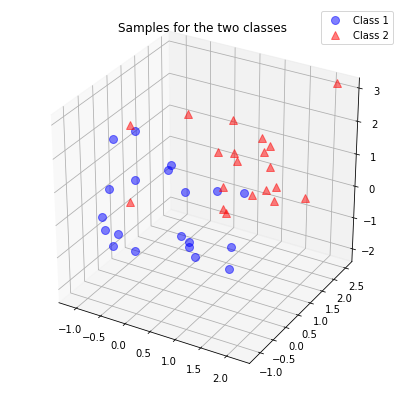

In [81]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10 

ax.plot(class1_samples[0,:], class1_samples[1,:], class1_samples[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='Class 1')
ax.plot(class2_samples[0,:], class2_samples[1,:], class2_samples[2,:], '^', markersize=8, color='red', alpha=0.5, label='Class 2')

plt.title('Samples for the two classes')
ax.legend(loc='upper right')

plt.show()

We can merge the samples into one $3$ X $40$-dimensional array. 

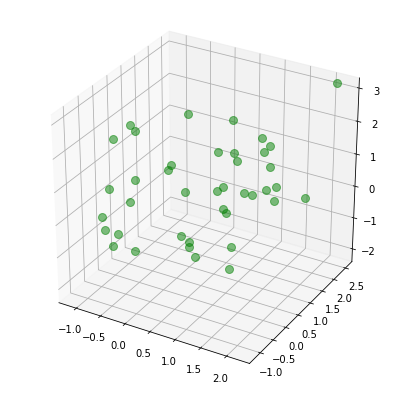

In [82]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10 

all_samples = np.concatenate((class1_samples, class2_samples), axis=1)
ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.5)

plt.show()

### Some essential computations

The next step is to compute the mean vector. It consists of the means of each variable.

In [83]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('The Mean Vector is:\n', mean_vector)

The Mean Vector is:
 [[0.41667492]
 [0.69848315]
 [0.49242335]]


We have come to a really important part of the process - computing the covariance matrix. Luckily, NumPy provides the in-built function `numpy.cov()` for us to use. Otherwise, it would have been a rather tedious process but if you are interested you can [give it a go](http://mathworld.wolfram.com/Covariance.html).    

In [84]:
covariance_matrix = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('The Covariance Matrix is:\n', covariance_matrix)

The Covariance Matrix is:
 [[0.9868668  0.26943262 0.2855759 ]
 [0.26943262 0.92914135 0.30682016]
 [0.2855759  0.30682016 1.27528118]]


### A return to Eigenworld 

It is finally time to compute some eigenvalues and eigenvectors from the covariance matrix in order to determine the principal components of the data. To put it as simply as possible, PCA tries to fit straight lines to the data points. The first principal component (that just so happens to be the eigenvector with the highest eigenvalue) is the best straight line we can fit to the data. It accounts for the largest possible variance in the data set. There are as principal components as there are variables. For example, 52-dimenstional data would give us the 52 principal components, but using PCA we put maximum possible information in the first component, then maximum remaining information in the second one (which is orthogonal to the first one) and so on.

While doing our computation we would also check if they satisfy the equation we talked about: $A\vec{v}=\lambda \vec{v}$, where $A$ is the Covariance matrix.

In [85]:
# Computing eigenvectors and eigenvalues from the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

for i in range(len(eigenvalues)):
    # Getting each separate eigenvector column 
    current_eigenvector = eigenvectors[:,i].reshape(1,3).T

    # Multiplying the covariance matrix with the current eigenvector
    matrix_vector_multiplication = covariance_matrix.dot(current_eigenvector)
    
    # Scaling the eigenvector by its eigenvalue
    scalar_multiplication = eigenvalues[i] * current_eigenvector
    
    # A check to make sure that the calculation satisfies the equation
    np.testing.assert_array_almost_equal(matrix_vector_multiplication, scalar_multiplication,
                                         decimal=6, err_msg='They are not equal', verbose=True)
    
    print('Eigenvector {}: \n{}'.format(i+1, current_eigenvector))
    print('Eigenvalue {} from the covariance matrix: {}'.format(i+1, eigenvalues[i]))
    print('\n')

Eigenvector 1: 
[[-0.49210223]
 [-0.47927902]
 [-0.72672348]]
Eigenvalue 1 from the covariance matrix: 1.6710094305328698


Eigenvector 2: 
[[-0.64670286]
 [-0.35756937]
 [ 0.67373552]]
Eigenvalue 2 from the covariance matrix: 0.8383259734158449


Eigenvector 3: 
[[ 0.58276136]
 [-0.8015209 ]
 [ 0.13399043]]
Eigenvalue 3 from the covariance matrix: 0.6819539303101814




The eigenvectors of the matrix should be orthogonal. Let's check that to make sure that our computations are correct. If the dot product of two vectors is $0$, they are orhogonal 

In [86]:
print(int(eigenvectors[0].dot(eigenvectors[1])))
print(int(eigenvectors[0].dot(eigenvectors[2])))
print(int(eigenvectors[2].dot(eigenvectors[1])))

0
0
0


Since we want to reduce the dimensionality of our feature space, the eigenvectors will help us a lot, because they will form the axes of the new, smaller subspace. However, we have to decide which eigentvectors we want to drop for our lower-dimesnsional subspace. As we have already mentioned, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data. Therefore, they are the once we want to drop. To do so, we will sort the eigenvectors by decreasing eigenvalues and choose the top eigenvectors.

In [88]:
# Make a list of (eigenvalue, eigenvector) tuples 
eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) tuples from high to low by eigenvalues
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

# Show the sorted eigenvalues
for i in eigen_pairs:
    print(i[0])

1.6710094305328698
0.8383259734158449
0.6819539303101814


In this step we are reducing a 3D space to a 2D subspace. This means that we need to combine the two eigenvectors with the highest eigenvalues to construct the new eigenvector matrix.

In [89]:
eigenvector_matrix = np.hstack((eigen_pairs[0][1].reshape(3,1), eigen_pairs[1][1].reshape(3,1)))
print('The eigenvector matrix is:\n', eigenvector_matrix)

The eigenvector matrix is:
 [[-0.49210223 -0.64670286]
 [-0.47927902 -0.35756937]
 [-0.72672348  0.67373552]]


### Final touches
In the last step, we use the newly created eigenvector matrix to transform our samples onto the new subspace.

In [90]:
# Creating the new matrix by stacking the arrays in sequence horizontally
eigenvector_matrix = np.hstack((eigen_pairs[0][1].reshape(3,1), eigen_pairs[1][1].reshape(3,1)))

# Subtracting the mean vector to center the data at the origin
transformed = eigenvector_matrix.T.dot(all_samples - mean_vector)

Finally, we can plot the the result. 

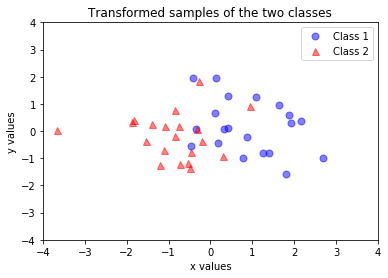

In [91]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='Class 1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='Class 2')

plt.xlim([-4,4])
plt.ylim([-4,4])

plt.xlabel('x values')
plt.ylabel('y values')

plt.legend()
plt.title('Transformed samples of the two classes')

plt.show()

### Comparison and Evaluation

Now that we have an idea of how principal component analysis works, we can use the PCA class from the from the machine-learning library [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). This will make sure that we have not made a mistake in our approach. Their implementation of PCA is a bit different from ours. It performs a [Singular Value Decomposition](https://blog.statsbot.co/singular-value-decomposition-tutorial-52c695315254) instead of obtaining the eigenvectors and eigenvalues from the covariance matrix like we did. 

Using scikit-learn we can specify to how many components we want to reduce our input. 

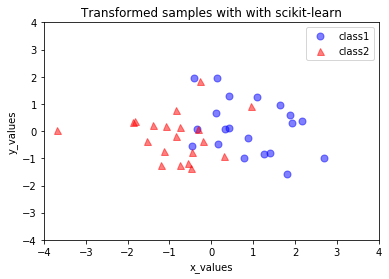

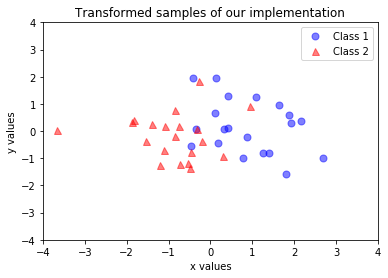

In [101]:
# Implementation with scikit-learn
sklearn_pca = sklearnPCA(n_components=2) # We want to reduce the dataset to 2 components
sklearn_transf = sklearn_pca.fit_transform(all_samples.T) # Performing the dimensionality reduction

# If we don't multiply by (-1) the result will be a mirror image of our approach, because of the signs of the eigenvectors
plt.plot(sklearn_transf[0:20,0]*(-1),sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='Class 1')
plt.plot(sklearn_transf[20:40,0]*(-1), sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='Class 2')

plt.xlabel('x values')
plt.ylabel('y values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with with scikit-learn')

plt.show()

# Our imlpementation
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='Class 1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='Class 2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.title('Transformed samples of our implementation')

plt.show()

If we compare both pictures, we can see that our approach worked just as well on the dataset as the scikit-learn one. 

### Pros and Cons of PCA

This algorithm, as all, is best suited for some circumstances and performs poorly in others. Probably the biggest pro, is the massive reduction in size of data. This leads to faster processing. If done properly it remains relatively accurate. Not only that but it also really great when it comes to data visualization. 

The biggest minus of PCA is its high computational cost, therefore it cannot be applied to very large datasets.

## Conclusion 

PCA plays an important role in the world of machine learning. It combines mathematics and statistics to bring to the table an amazing technique that has a numerous applications in different spheres. Most notably it can be used to find patterns, to compress images and, of course, data representation.  A detailed implentation of the algorithm has been provided. 

## References

1. https://skymind.ai/wiki/eigenvector
2. https://file.scirp.org/pdf/JSIP_2013101711003963.pdf
3. https://en.wikipedia.org/wiki/Principal_component_analysis
4. http://www.math.harvard.edu/~elkies/M21b.08/det.html
5. https://simple.wikipedia.org/wiki/Standard_deviation
6. https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2
7. https://sebastianraschka.com/Articles/2014_pca_step_by_step.html
8. https://www.mathsisfun.com/data/standard-deviation.html
9. https://www.investopedia.com/terms/v/variance.asp
10. https://datascienceplus.com/understanding-the-covariance-matrix/
11. https://www.calvin.edu/~scofield/courses/m256/materials/eigenstuff.pdf
12. https://courses.cs.washington.edu/courses/csep546/16sp/slides/PCA_csep546.pdf
13. http://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/
14. [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw)
